In [1]:
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [2]:
class OMSVM_OAF_Forward:
    """
    Ordinal Multi-class SVM: One-Against-Followers (OAF) + Forward Fusion.
    This is your primary model for performance evaluation.
    """
    def __init__(self, kernel='rbf', C=1.0, gamma='scale'):
        self.svm_params = {'kernel': kernel, 'C': C, 'gamma': gamma, 'probability': True, 'random_state': 42}
        self.classes_ = None
        self.classifiers_ = []

    def fit(self, X, y):
        X_np = X.values if isinstance(X, pd.DataFrame) else X
        y_np = y.values if isinstance(y, (pd.Series, pd.DataFrame)) else y
        self.classes_ = np.sort(np.unique(y_np))
        self.classifiers_ = []
        for i, k in enumerate(self.classes_[:-1]):
            followers = self.classes_[i+1:]
            mask = np.isin(y_np, np.r_[k, followers])
            X_sub, y_sub = X_np[mask], y_np[mask]
            y_bin = (y_sub != k).astype(int)
            clf = SVC(**self.svm_params)
            clf.fit(X_sub, y_bin)
            self.classifiers_.append(clf)
        return self
    
    def predict(self, X):
        if not self.classifiers_:
            raise RuntimeError("Model is not trained yet. Please call .fit() first.")
        X_np = X.values if isinstance(X, pd.DataFrame) else X
        preds = []
        for row in X_np:
            x = row.reshape(1, -1)
            predicted_class = self.classes_[-1]
            for i, clf in enumerate(self.classifiers_):
                if clf.predict(x)[0] == 0:
                    predicted_class = self.classes_[i]
                    break
            preds.append(predicted_class)
        return np.array(preds)

In [3]:
try:
    file_path = r'C:/Users/Asus/Documents/Akademik/Skripsi/Analisis/Data/DataPariwisataSRS_2.xlsx'
    df = pd.read_excel(file_path, sheet_name='Sheet3')
    print("Data loaded successfully! Preview:")
    print(df.head())

    Y = df['Y'].astype(int)
    X = df[['X1', 'X2', 'X3', 'X4', 'X5']]

    # Split data into training and testing sets (no SMOTE)
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=Y
    )
    print(f"\nData split: Train={len(X_train)} samples, Test={len(X_test)} samples.")

except FileNotFoundError:
    print(f"Error: File not found at '{file_path}'. Please check your path.")
    exit()


Data loaded successfully! Preview:
         X1        X2        X3        X4        X5  Y
0  5.033624  5.572718  5.646153  5.657581  5.580480  3
1  5.033624  5.532961  5.646153  5.657581  5.122312  2
2  5.832721  4.932921  5.602360  6.074165  4.699722  2
3  5.033624  6.172758  4.938446  5.631726  4.684519  2
4  4.319413  5.572718  4.938446  5.215142  5.157890  3

Data split: Train=78 samples, Test=20 samples.


In [4]:
print("\n--- Training Your Main Model: OMSVM_OAF_Forward ---")
main_model = OMSVM_OAF_Forward(kernel='rbf', C=10, gamma=0.1)
main_model.fit(X_train, y_train)
print("Main model training complete!")


--- Training Your Main Model: OMSVM_OAF_Forward ---
Main model training complete!


In [5]:
print("\n--- Main Model Evaluation (on Test Set) ---")
y_pred = main_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(classification_report(y_test, y_pred))


--- Main Model Evaluation (on Test Set) ---
Accuracy: 60.00%
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.60      0.82      0.69        11
           3       0.60      0.38      0.46         8

    accuracy                           0.60        20
   macro avg       0.40      0.40      0.38        20
weighted avg       0.57      0.60      0.57        20



d:\ANACONDA\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\ANACONDA\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\ANACONDA\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [6]:
print(f"\n{'='*20}\n SHAP INTERPRETATION \n{'='*20}")
print("Note: We're training a standard SVC model on the same data for a stable SHAP analysis.")


 SHAP INTERPRETATION 
Note: We're training a standard SVC model on the same data for a stable SHAP analysis.


In [7]:
proxy_model = SVC(kernel='rbf', C=10, gamma=0.1, probability=True, random_state=42)
proxy_model.fit(X_train, y_train)
print("Proxy SVC model for SHAP has been trained.")

Proxy SVC model for SHAP has been trained.


In [8]:
X_background = shap.kmeans(X_train, 10)
explainer = shap.KernelExplainer(proxy_model.predict_proba, X_background)
print("SHAP explainer is ready.")

d:\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


SHAP explainer is ready.


In [9]:
print("\nCalculating SHAP values... This may take a moment.")
shap_values = explainer.shap_values(X_test)
print("SHAP values calculated successfully.")


Calculating SHAP values... This may take a moment.


  0%|          | 0/20 [00:00<?, ?it/s]

SHAP values calculated successfully.


In [10]:
shap.initjs() # Initialize JavaScript visualization in your environment



Displaying Beeswarm Plot...


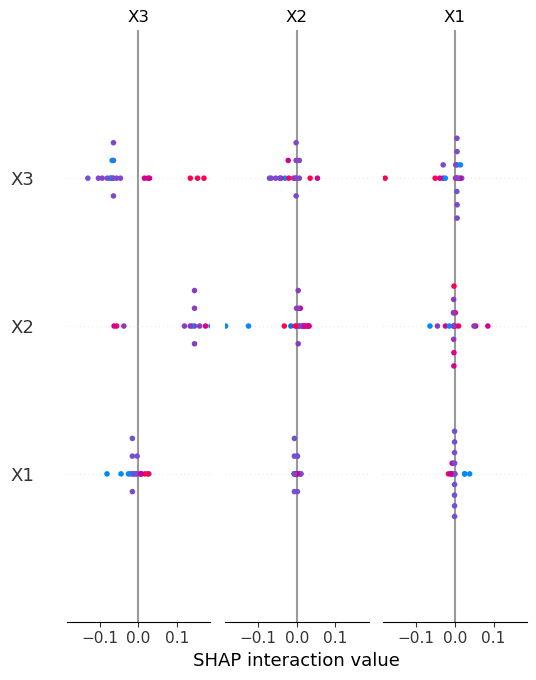

In [11]:
# --- Beeswarm Plot (Global Feature Importance) ---
print("\nDisplaying Beeswarm Plot...")
# This plot shows the overall feature importance and effect.
shap.summary_plot(shap_values, X_test)


Displaying Bar Plot...


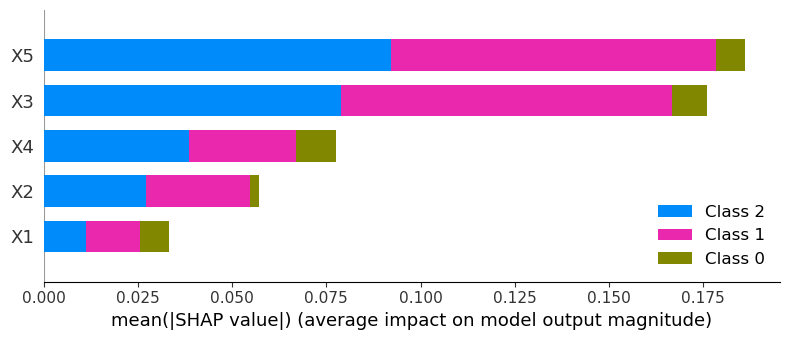

In [12]:
print("\nDisplaying Bar Plot...")
# This plot simplifies the beeswarm into average impact per feature.
shap.summary_plot(shap_values, X_test, plot_type="bar")



Displaying Waterfall Plot for a single prediction...

Showing waterfall plot for sample #0, explaining prediction for Class 3


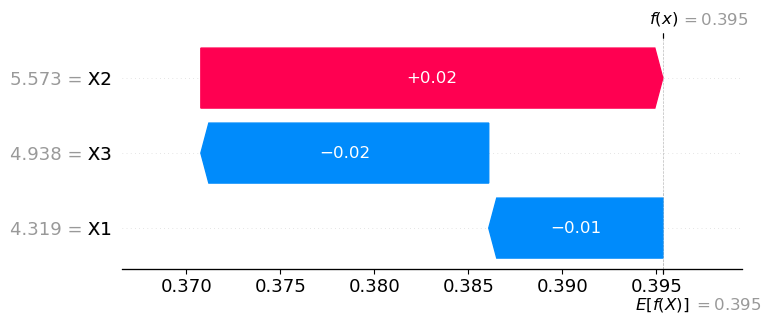

In [14]:
# --- Waterfall Plot (Explaining a Single Prediction) ---
print("\nDisplaying Waterfall Plot for a single prediction...")
sample_to_explain = 0 
class_to_explain_index = 2 

explanation = shap.Explanation(
    # Nilai SHAP untuk sampel dan kelas yang dipilih
    values=shap_values[class_to_explain_index][sample_to_explain],
    
    # Nilai dasar (rata-rata prediksi) untuk kelas yang dipilih
    base_values=explainer.expected_value[class_to_explain_index],
    
    # Data asli (nilai fitur) dari sampel yang dipilih
    data=X_test.iloc[sample_to_explain],
    
    # Nama-nama fitur
    feature_names=X_test.columns
)

# Menampilkan plot
print(f"\nShowing waterfall plot for sample #{sample_to_explain}, explaining prediction for Class {class_to_explain_index + 1}")
shap.plots.waterfall(explanation)
